# US CPI, Fed Funds Effective Rate, and Market Yield on US Treasury Securities at 10-Year
This notebook jaxteposes the evolution of US seasonally adjusted CPI with Fed Funds Effective Rate and 10 year US Treasury yield. Most of the time the Fed Funds rate and 10 year treasury yields have been slightly above the CPI, yet this is not the case from 2021 anymore. Whereever possible I make use of data series with monthly frequencies provided by [FRED](https://fred.stlouisfed.org/). In cases where only daily freqencies are available, I downsample to month end.

The notebook also looks forwards by comparing the present US Treasury Yield Curve with US Annual Inflation Expectations based on the breakeven inflation rates. The breakeven inflation rate represents a measure of expected inflation derived from N-Year Treasury Constant Maturity Securities and N-Year Treasury Inflation-Indexed Constant Maturity Securities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

### Get Consumer Price Index for All Urban Consumers, Fed Funds Effective Rate, and 10 Year US Treasury Yield
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency, from 1947)
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency, from 1953)

In [3]:
fred_cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS', 'GS10'], start=report_start, end=report_end)

In [4]:
# Since CPIAUCSL is indexed to 1982-1984=100, we need to convert it to annual percentage changes
fred_cpi_ffr.update(fred_cpi_ffr.CPIAUCSL.pct_change(12)*100)
fred_cpi_ffr = fred_cpi_ffr.loc['1970':]
fred_cpi_ffr.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI', 'FEDFUNDS': 'Federal Funds Effective Rate',
             'GS10': '10y Treasury Yield'},
    inplace=True)
fred_cpi_ffr

,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield
DATE,,,
1970-01-01,6.162465,8.98,7.79
1970-02-01,6.424581,8.98,7.24
1970-03-01,6.094183,7.76,7.07
1970-04-01,6.060606,8.10,7.39
1970-05-01,6.043956,7.95,7.91
...,...,...,...
2022-02-01,7.912024,0.08,1.93
2022-03-01,8.557586,0.20,2.13
2022-04-01,8.224139,0.33,2.75


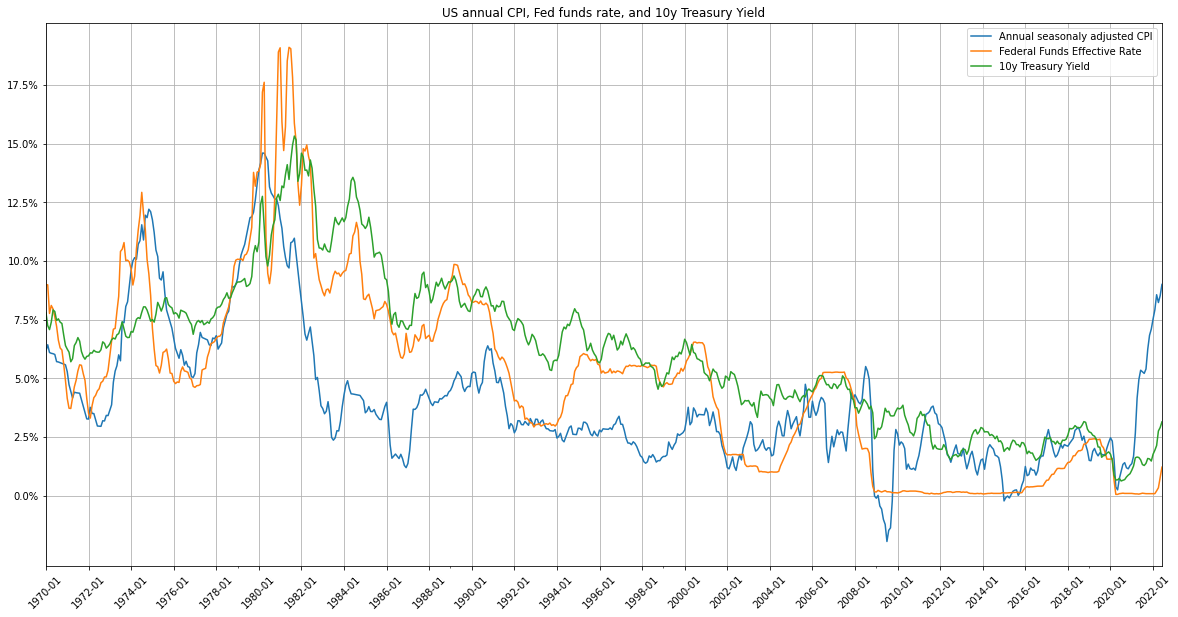

In [5]:
ax = fred_cpi_ffr.plot(figsize=(20,10), grid=True, title='US annual CPI, Fed funds rate, and 10y Treasury Yield',
                       xticks=fred_cpi_ffr.index[::24], xlabel='', rot=45, yticks=np.arange(0, 20, 2.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_cpi_ffr.index[::24])))

### Analyzing US Treasury Curve and US Annual Inflation Expectations
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `DGS1MO` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3MO` &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS6MO` &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS2` &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS3` &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS5` &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS7` &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS30` &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `T5YIEM` &mdash; 5-Year Breakeven Inflation Rate (monthly frequency)
* `T7YIEM` &mdash; 7-Year Breakeven Inflation Rate (monthly frequency)
* `T10YIEM` &mdash; 10-Year Breakeven Inflation Rate (monthly frequency)
* `T20YIEM` &mdash; 20-Year Breakeven Inflation Rate (monthly frequency)
* `T30YIEM` &mdash; 30-Year Breakeven Inflation Rate (monthly frequency)

#### Retrieving and preparing data for US Treasury Yield Curve construction

In [6]:
report_start = date.fromisoformat('2012-01-01')

# Treasury yield curve
data = web.get_data_fred(['FEDFUNDS', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30'], report_start, report_end)
data.dropna(inplace=True)

# The following data series are only provided with daily frequences, hence we need to downsample them
data2 = web.get_data_fred(['DGS1MO', 'DGS3MO', 'DGS6MO'], report_start, report_end)
data2 = data2.resample('MS').last()

data = pd.concat([data, data2], axis=1).dropna()

# Rearranging columns
data = data[['FEDFUNDS', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30']]

# Renaming to reflect quarterly frequencie in the columns that use to have monthly
data.rename(columns={'DGS1MO': 'GS1MO', 'DGS3MO': 'GS3MO', 'DGS6MO': 'GS6MO'}, inplace=True)

In [7]:
data

,FEDFUNDS,GS1MO,GS3MO,GS6MO,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30
DATE,,,,,,,,,,,,
2012-01-01,0.08,0.04,0.06,0.08,0.12,0.24,0.36,0.84,1.38,1.97,2.70,3.03
2012-02-01,0.10,0.08,0.08,0.13,0.16,0.28,0.38,0.83,1.37,1.97,2.75,3.11
2012-03-01,0.13,0.05,0.07,0.15,0.19,0.34,0.51,1.02,1.56,2.17,2.94,3.28
2012-04-01,0.14,0.07,0.10,0.15,0.18,0.29,0.43,0.89,1.43,2.05,2.82,3.18
2012-05-01,0.16,0.03,0.07,0.14,0.19,0.29,0.39,0.76,1.21,1.80,2.53,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,0.08,0.06,0.35,0.69,1.00,1.44,1.65,1.81,1.91,1.93,2.31,2.25
2022-03-01,0.20,0.17,0.52,1.06,1.34,1.91,2.09,2.11,2.15,2.13,2.51,2.41
2022-04-01,0.33,0.37,0.85,1.41,1.89,2.54,2.72,2.78,2.80,2.75,2.99,2.81


#### Retrieving data for inflation expectaions curve construction

In [8]:
# Inflation expectaions
data_infl = web.get_data_fred(['T5YIEM', 'T7YIEM', 'T10YIEM', 'T20YIEM', 'T30YIEM'], report_start, report_end)
data_infl.dropna(inplace=True)

# Adding CPI
data_infl = pd.concat([fred_cpi_ffr[['Annual seasonaly adjusted CPI']].loc['2012':], data_infl], axis=1).dropna()

In [9]:
data_infl

,Annual seasonaly adjusted CPI,T5YIEM,T7YIEM,T10YIEM,T20YIEM,T30YIEM
DATE,,,,,,
2012-01-01,3.008766,1.76,1.93,2.08,2.19,2.29
2012-02-01,2.898178,1.94,2.06,2.22,2.30,2.39
2012-03-01,2.582875,2.05,2.13,2.31,2.38,2.41
2012-04-01,2.273163,1.95,2.08,2.26,2.32,2.39
2012-05-01,1.737943,1.88,2.00,2.14,2.09,2.25
...,...,...,...,...,...,...
2022-02-01,7.912024,2.87,2.69,2.46,2.44,2.18
2022-03-01,8.557586,3.41,3.14,2.85,2.81,2.49
2022-04-01,8.224139,3.32,3.12,2.88,2.86,2.55


#### Constructing US Treasury Yield and Inflation expectations curves

In [10]:
date = data.index[-1].date()
date_1_year_ago = date + relativedelta(years=-1)
date_2_years_ago = date + relativedelta(years=-2)
date_5_years_ago = date + relativedelta(years=-5)
date_10_years_ago = date + relativedelta(years=-10)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Unfortunately fewer curve points for US Inflation expectations
offsets_infl = [relativedelta(), relativedelta(years=+5), relativedelta(years=+7),
                relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Define US Treasury yield curves
curve = curves.YieldCurve(date, offsets, data[date:date+BDay()].to_numpy()[0,:])
curve_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets,
                                     data[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets,
                                      data[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets,
                                      data[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])
curve_10_years_ago = curves.YieldCurve(date_10_years_ago, offsets,
                                       data[date_10_years_ago:date_10_years_ago+BDay()].to_numpy()[0,:])

# Define US Inflation expectations curves
curve_infl = curves.YieldCurve(date, offsets_infl, data_infl[date:date+BDay()].to_numpy()[0,:])
curve_infl_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets_infl,
                                          data_infl[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_infl_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets_infl,
                                          data_infl[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_infl_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets_infl,
                                          data_infl[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])

#### Visualizing current  US Treasury Yield and US Inflatio Expectations Curves

In [11]:
curve_points = curve.get_curve_points(120)
curve_points_infl = curve_infl.get_curve_points(120)
curve_points.rename('US Treasury Yield', inplace=True)
curve_points_infl.rename('US Annual Inflation Expectations', inplace=True)
df = pd.concat([curve_points, curve_points_infl], axis=1)

In [12]:
df

,US Treasury Yield,US Annual Inflation Expectations
2022-06-01,1.210000,8.995221
2022-09-01,1.720915,8.313301
2022-12-02,2.517398,7.683404
2023-03-04,2.744815,7.103459
2023-06-04,2.646551,6.571400
...,...,...
2051-05-31,3.367415,2.606798
2051-08-31,3.340742,2.575680
2051-12-01,3.312307,2.542539
2052-03-02,3.282073,2.507328


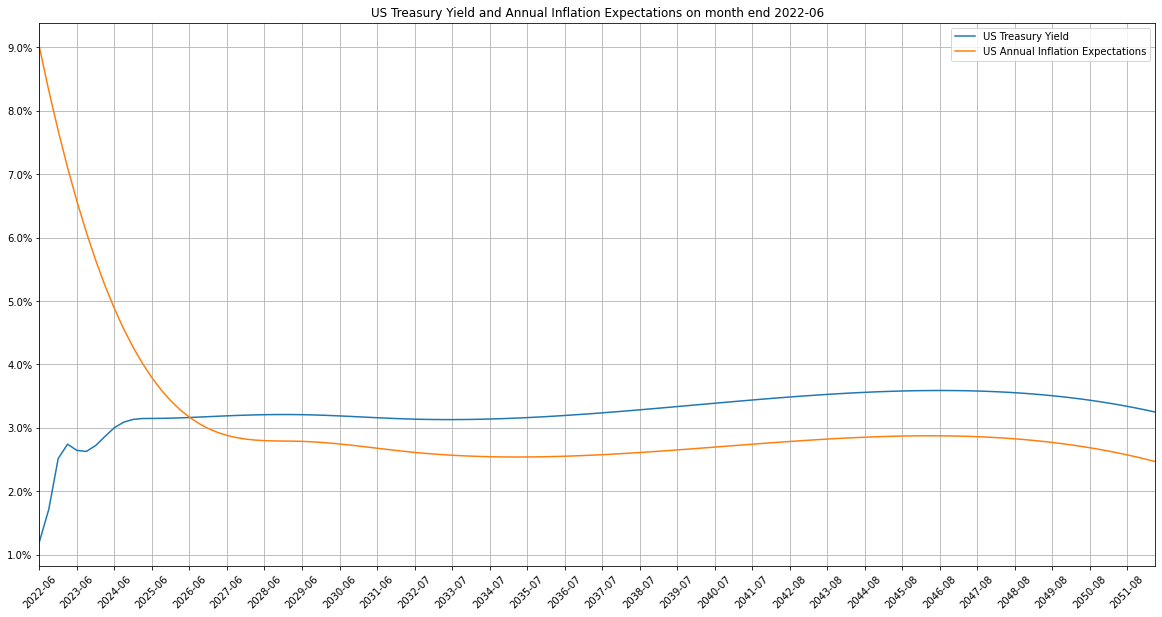

In [13]:
ax = df.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]),
             xticks=df.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df.index[::4])))

#### Visualizing US Treasury Yield and US Inflatio Expectations Curves 1, 2, and 5 years ago 

In [14]:
curve_points_1_year_ago = curve_1_year_ago.get_curve_points(120)
curve_points_infl_1_year_ago = curve_infl_1_year_ago.get_curve_points(120)
curve_points_1_year_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_1_year_ago.rename('US Annual Inflation Expectations', inplace=True)
df_1_year_ago = pd.concat([curve_points_1_year_ago, curve_points_infl_1_year_ago], axis=1)

In [15]:
curve_points_2_years_ago = curve_2_years_ago.get_curve_points(120)
curve_points_infl_2_years_ago = curve_infl_2_years_ago.get_curve_points(120)
curve_points_2_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_2_years_ago.rename('US Annual Inflation Expectations', inplace=True)
df_2_years_ago = pd.concat([curve_points_2_years_ago, curve_points_infl_2_years_ago], axis=1)

In [16]:
curve_points_5_years_ago = curve_5_years_ago.get_curve_points(120)
curve_points_infl_5_years_ago = curve_infl_5_years_ago.get_curve_points(120)
curve_points_5_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_5_years_ago.rename('US Annual Inflation Expectations', inplace=True)
df_5_years_ago = pd.concat([curve_points_5_years_ago, curve_points_infl_5_years_ago], axis=1)

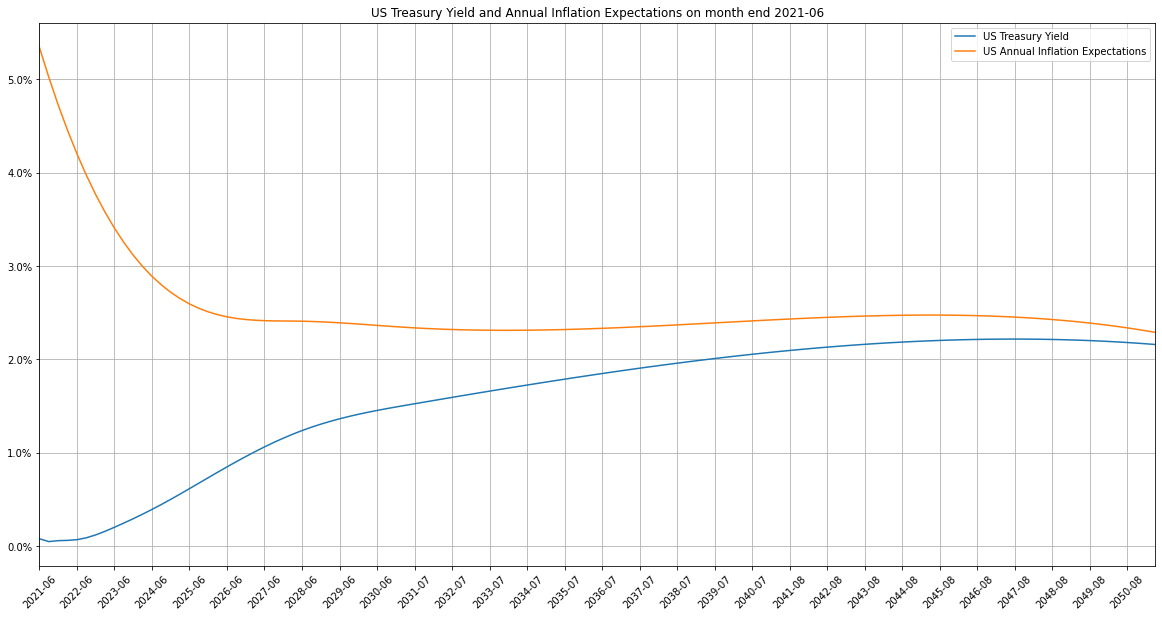

In [17]:
ax = df_1_year_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_1_year_ago.strftime('%Y-%m'),
             xlim=(df_1_year_ago.index[0], df_1_year_ago.index[-1]),
             xticks=df_1_year_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_1_year_ago.index[::4])))

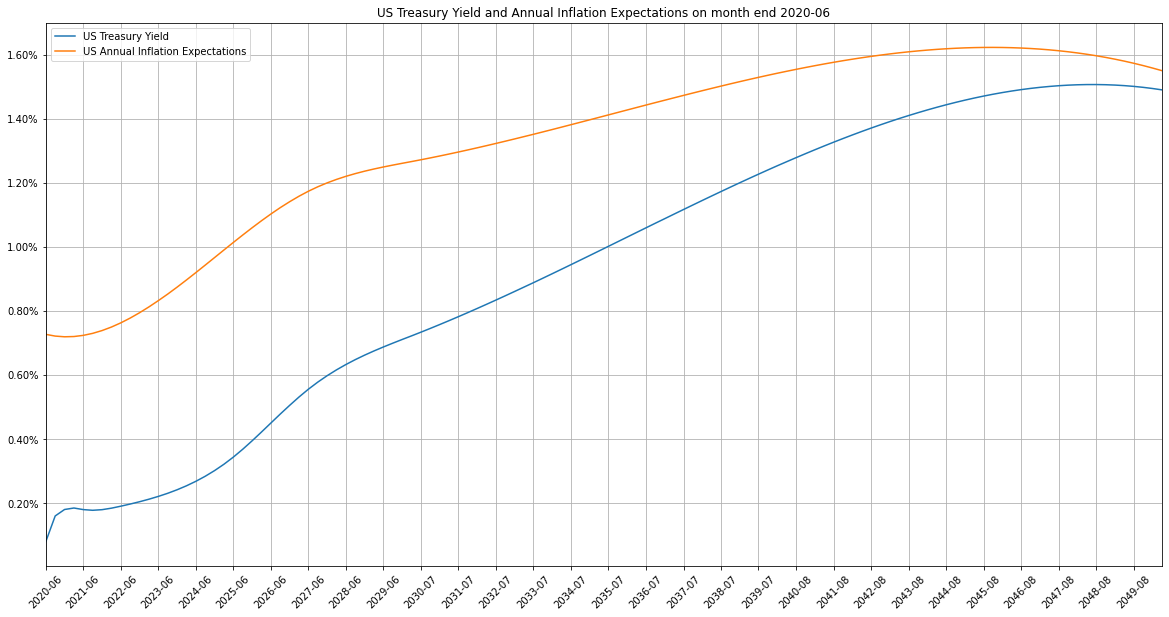

In [18]:
ax = df_2_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_2_years_ago.strftime('%Y-%m'),
             xlim=(df_2_years_ago.index[0], df_2_years_ago.index[-1]),
             xticks=df_2_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_2_years_ago.index[::4])))

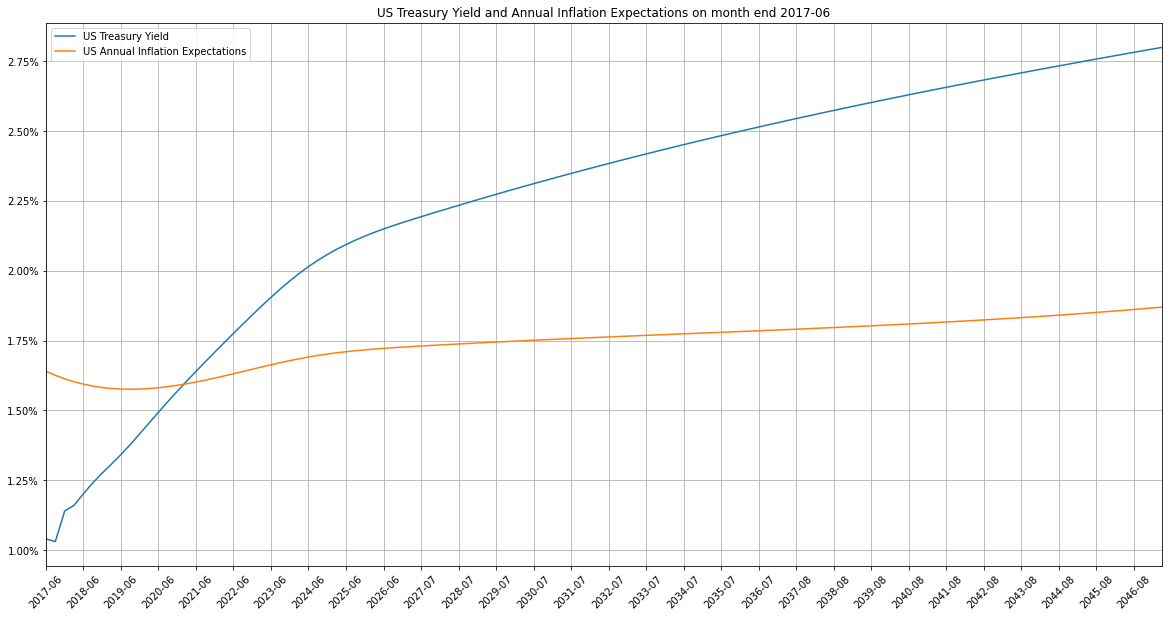

In [19]:
ax = df_5_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_5_years_ago.strftime('%Y-%m'),
             xlim=(df_5_years_ago.index[0], df_5_years_ago.index[-1]),
             xticks=df_5_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_5_years_ago.index[::4])))